# Traffic Monitoring (v2.0)
This notebook is a working document to suppliement the traffic monitoring implementation.  The main application is intedded to be run from a docker image.

This notebook will use any available video stream as its source.  YOLO detection will be applied one per second of video streaming.  Bounding boxes of detected objects will be display in a Python video window.  Detections are saved to a local log file each minute.

See <a href='./README.md'>README.md</a> for additional details.

When the detection cell is started, a python pop-up window will display the streaming content with detection boxes.

### To stop video
Press `q` to quit the pop-up window.


### Referecnes
Detection is supported by an ImageAi library:
https://imageai.readthedocs.io/en/latest/detection/index.html


### Set Local Variables
When running docker image, these are set as environment variables.

In [1]:
import os
# Set sources for notebook - emulates -e switches in docker run statement

# Stream YouTube Video
os.environ["CAM_STREAM"]   = '1EiC9bvVGnk' #PSf09R3D7Lo #https://www.youtube.com/embed/1EiC9bvVGnk

# Stream local webcam
# os.environ["CAM_STREAM"]  = "http://pidev1.local:8080/?action=stream"

os.environ["LOGGING"]     = "True"
os.environ["MODEL"]       = "yolo"     # 'tinyyolo' also supported
os.environ["DETECTION"]   = "True"     # setting to false will simply stream video
os.environ["DETECTOR"]    = "imageai"  # only imageai supported for now
os.environ["DPM"]         = "20"
os.environ["DISPLAY_FPS"] = "30"
os.environ["SHOW_VIDEO"]  = "True"



In [24]:
import warnings
import cv2
import time
import numpy as np
from modules.logging.logging_thread import LoggingThread
from modules.monitoring.monitoring_thread import Monitor
from modules.Video_Capture.video_capture_thread import VideoCaptureThread
from modules.queue_service import QueueService
from modules.parameters import Params

# establish parameters
p = Params()

warnings.filterwarnings('ignore')


def stream_object_detection():
    """
    This routine will stream a video and perform object detection
    on frames captured from the video.
    Object detection is auto-throttled by the corresponding
    read_thread.

    This routine uses threading to improve performance.  The main
    thread will display images.  The read_thread will capture
    images from the source and perform inference.  The rate of
    inference is auto-throttled.

    If logging is enabled, the read_thread will launch a sub-thread
    that will log the detection statistics to file once per minute.

    If monitoring is enabled (true by default), a monitoring thread
    is launched.

    The routine can be stopped by pressing 'q' while the video
    window is selected.

    """

    def terminate_threads():
        for t in thread_list:
            print("Closing '{}' ... ".format(t.getName()), end='\r')
            t.stop()  # signal thread to stop
            t.join()  # wait until it is stopped
            print("'{}' closed!     ".format(t.getName()))

    # def add_overlay(frame: np.array, stats:dict = None) -> np.array:
    def add_overlay() -> np.array:
        """
        Adds overly to current 'frame'.  Uses local variables
        stats and frame.  'stats' is a dictionary
        where keys are displayed statistics and values are the
        respective values.
        """
        # HELP MENU
        cv2.putText(frame, "{}".format("'q' - quit"),
                    (10, frame.shape[0] - 10),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 200, 0),
                    thickness=1)

        # STATISTICS
        # cv2.putText(frame, "{}".format("dpm: {}".format(round(capture_thread.get_dpm(), 1))),
        for i, (k, v) in enumerate(stats.items()):
            cv2.putText(frame, "{:6} : {}".format(k, round(v, 3)),
                        (frame.shape[1] - 100, frame.shape[0] - 10 - (i*15)),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.4,
                        color=(0, 200, 0),
                        thickness=1)

    # set display window title bar text
    window_name = "Traffic Monitor"

    # establish queue service
    qs = QueueService()

    # list of threads
    thread_list = []

    # start thread to capture video stream
    capture_thread = VideoCaptureThread()  # dpm=get_dpm(), display_fps=get_display_fps())
    capture_thread.setName("capture-thread")
    capture_thread.start()
    thread_list.append(capture_thread)

    # get the source's fps rate
    # cam_fps = 0
    # while cam_fps == 0:
    #     cam_fps = capture_thread.get_camfps()
    #     time.sleep(.2)
    #     print("waiting for fps rate....", end='')
    # print("FPS={}".format(cam_fps))

    # start logging thread
    if p.LOGGING:  # os.getenv("LOGGING", "True") == "True":
        logging_thread = LoggingThread(capture_thread)  # (detections_queue,capture_thread)
        logging_thread.setName("logging-thread")
        logging_thread.start()
        thread_list.append(logging_thread)

    # start monitoring thread
    if p.MONITORING:  # os.getenv("MONITORING", "True") == "True":
        monitoring_thread = Monitor()  # (mon_queue=mon_queue)
        monitoring_thread.setName("monitoring-thread")
        monitoring_thread.start()
        thread_list.append(monitoring_thread)

    # simplify access to elapsed time
    start_time = time.perf_counter()
    elapsed_time = lambda: time.perf_counter() - start_time

    # initialize variables
    last_display_time = 0
    delay = 0  # .03 Set to smooth video - adjusted with '[' and ']' keys.
    t_delay = 0

    # main display loop - main thread
    while True:

        if elapsed_time() - last_display_time < 1 / p.CAM_FPS:  # cam_fps:
            continue

        print("{:90}".format(" "), end='\r')  # clear line
        print("Elapsed time: {:<8} Buffer size: {:<3} delay: {}".format(round(elapsed_time(), 1), qs.ref_queue.qsize(), delay), end='\r')

        try:
            frame_num, source_queue = qs.ref_queue.get()
            qs.ref_queue.task_done()
            frame_num, frame = source_queue.get()
            source_queue.task_done()

            last_display_time = elapsed_time()

            if p.SHOW_VIDEO:  # os.getenv("SHOW_VIDEO", "True") == "True":

                # frame overlay
                stats = {}
                stats.setdefault('dpm', round(p.DPM, 1))
                stats.setdefault('delay', t_delay)
                add_overlay()

                # update window
                cv2.imshow(window_name, frame)

                # wait briefly to interpret keystroke
                keypress = cv2.waitKeyEx(1)
                if keypress == 113:  # cv2.waitKeyEx(1) & 0xFF == ord('q'):
                    print("\nTerminating video feed! 'q' Pressed.")
                    cv2.destroyWindow(window_name)
                    cv2.waitKey(1)  # flushes command
                    break
                elif keypress == 32:  # space bar
                    cv2.imwrite("./logdir/{}.png".format(elapsed_time()), frame)
                    # time.sleep(.05)
                elif keypress == 93:  # left bracket
                    delay += .005
                elif keypress == 91:  # right bracket
                    delay = max((0, delay - .005))

                # pause to smooth video stream
                # delay = .03
                # pause extra to display captures
                frame_delay = 0
                if source_queue is qs.det_queue:
                    frame_delay += .25
                # pause more as buffer gets smaller
                t_delay = 1 / (qs.ref_queue.qsize() + 2) + delay + frame_delay
                time.sleep(t_delay)

        except Exception as e:  # in case of failure, continue
            print("Main thread: {}".format(e))
            continue

    # terminate threads
    terminate_threads()



YouTube Video Stream Detected!
Video Resolution : 640x360
Video Test       : OK
TRAFFIC DETECTION PARAMETERS:

	CAM_STREAM    : https://manifest.googlevideo.com/api/manifest/hls_playlist/expire/1577995432/ei/SPgNXp3xJoHphwah45vgDA/ip/66.31.202.202/id/1EiC9bvVGnk.1/itag/93/source/yt_live_broadcast/requiressl/yes/ratebypass/yes/live/1/goi/160/sgoap/gir%3Dyes%3Bitag%3D140/sgovp/gir%3Dyes%3Bitag%3D134/hls_chunk_host/r5---sn-bvvbax-cvns.googlevideo.com/playlist_type/DVR/mm/44/mn/sn-bvvbax-cvns/ms/lva/mv/u/mvi/4/pl/22/dover/11/keepalive/yes/fexp/23842630,23860862/mt/1577973515/disable_polymer/true/sparams/expire,ei,ip,id,itag,source,requiressl,ratebypass,live,goi,sgoap,sgovp,playlist_type/sig/ALgxI2wwRQIhAK9Vm5FhiU9gr9Hnf0_-InqRfDzUojgwIEB-flnzNIhfAiBRo3O6BXuWMfEl_173wfFu9yHFK262qvr5Ujz-Gl_6dw%3D%3D/lsparams/hls_chunk_host,mm,mn,ms,mv,mvi,pl/lsig/AHylml4wRAIgfXxsQTup0-S7SBcF56ok4GXzWvy5aGN6C3M2MQSIbrwCIGoibodz1LVkiR0MXXy9ZkqDX9ZbNdAdTJbns1APLu7H/playlist/index.m3u8
	CAM_FPS       : 30.0
	LOG

In [7]:
# Start object detection
# press 'q' when video window is selected to stop.
stream_object_detection()

YouTube Video Stream Detected!
Video Resolution : 640x360
Video Source     : https://manifest.googlevideo.com/api/manifest/hls_playlist/expire/1577493552/ei/0E8GXt2eGMb4igTwsoaQDg/ip/173.28.251.0/id/1EiC9bvVGnk.1/itag/93/source/yt_live_broadcast/requiressl/yes/ratebypass/yes/live/1/goi/160/sgoap/gir%3Dyes%3Bitag%3D140/sgovp/gir%3Dyes%3Bitag%3D134/hls_chunk_host/r5---sn-vgqsenl7.googlevideo.com/playlist_type/DVR/initcwndbps/17490/mm/44/mn/sn-vgqsenl7/ms/lva/mv/m/mvi/4/pl/22/dover/11/keepalive/yes/fexp/23842630/mt/1577471842/disable_polymer/true/sparams/expire,ei,ip,id,itag,source,requiressl,ratebypass,live,goi,sgoap,sgovp,playlist_type/sig/ALgxI2wwRQIhAMQ8SdqPfZK960xE_EdyetY1xJnbkf62fieu5rzvMJZpAiAm5BcUtQAM4xIm-NeRdz8tkRYl5_euDIo3JMtLrx9hSA%3D%3D/lsparams/hls_chunk_host,initcwndbps,mm,mn,ms,mv,mvi,pl/lsig/AHylml4wRgIhAK4Mm1h1QXtSuI_4EaNzuRU4_AmTj7Fh2pg2jkSbpeK7AiEAplfbhNRIb42xW7v0HMxROcf8gkMK7BPK8faJ6XM7pAg%3D/playlist/index.m3u8
Video Test       : OK
CAM SETUP:
	Detection        : ON
	

## View Traffic Statistics
This section can be updated at any time while the docker image is running.  

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
%matplotlib inline

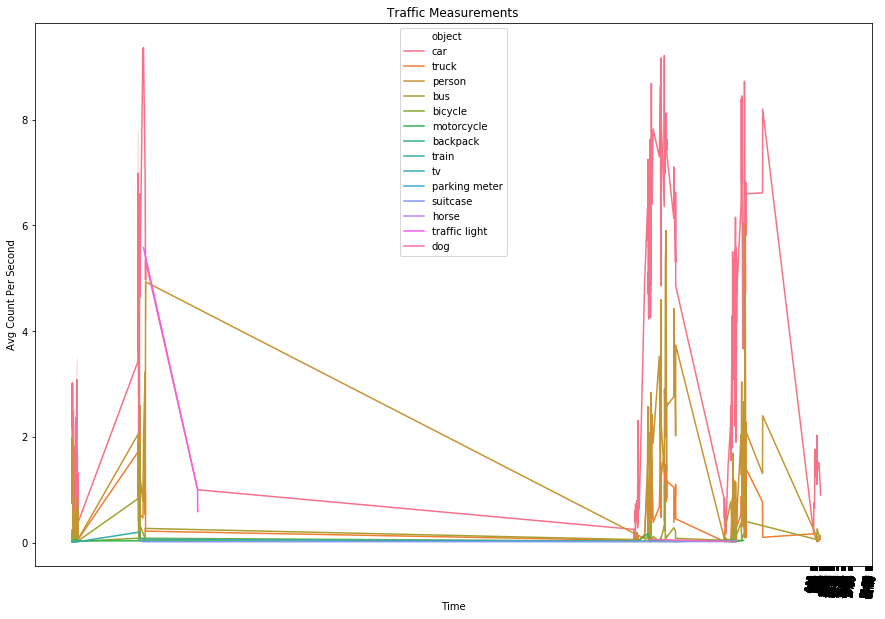

In [10]:
fig, ax = plt.subplots(figsize=(15,10))


log_data = pd.read_csv("./logdir/camlogs.txt", delimiter="|")
log_data['date_time'] = pd.to_datetime(log_data['date_time'])

sb.lineplot(data=log_data, x="date_time", y="count", hue="object", ax=ax)
ax.set_xticklabels(["{}:{:02}".format(x.hour,x.minute) for x in log_data.date_time.dt.time], rotation=80, fontsize=8);
ax.set_xticks(["{}:{:02}".format(x.hour,x.minute) for x in log_data.date_time.dt.time])
ax.set_title("Traffic Measurements")
ax.set_xlabel("Time")
ax.set_ylabel("Avg Count Per Second");
